In [217]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import theano.tensor as T
from theano import function, printing
import theano

from theano import config
# config.device = 'cpu'
# config.gcc.cxxflags = "-D_hypot=hypot"
config.compute_test_value = 'off'
import os
os.environ["THEANO_FLAGS"] = "exception_verbosity=high,on_opt_error=optimizer_excluding=ShapeOpt:local_lift_transpose_through_dot:scan_opt"
from theano.compile.nanguardmode import NanGuardMode
# config.NanGuardMode.action == 'pdb'


# updates = OrderedDict()

In [175]:
np.sum(np.exp([264.00000191,  348.66111496,  380.7460759,   393.88015476]))

1.148097052376827e+171

In [215]:
np.log(1)

0.0

In [166]:
a = [1.17811826e-138, 2.00887089e-139, 1.45461041e-091, 3.51945665e-125, 1.45461041e-091, 6.20902985e-134, 6.29818988e-089]
b = [0.93999999999999995, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
a*b

TypeError: can't multiply sequence by non-int of type 'list'

In [162]:
import math
no_z = [1.72855408e-123, 1.41612665e-115, 1.16040126e-107, 9.50931724e-20]

order = int(-math.log10(min(no_z)))
sf = 10**order
print("sf", sf)
scaled = [x * sf for x in no_z]
print("scaled", scaled)
tot = sum(scaled)
norm = [x/tot for x in scaled]
norm

sf 100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
scaled [0.17285540800000002, 14161266.5, 1160401260000000.0, 9.50931724e+102]


[1.817747832335437e-104, 1.489199081552568e-96, 1.220278207902127e-88, 1.0]

In [208]:
a = np.array([[1,7,8,4],
     [5,2,6,0],
     [3,10,4,9]])
np.sort(a, axis=0)[::-1].T


array([[ 5,  3,  1],
       [10,  7,  2],
       [ 8,  6,  4],
       [ 9,  4,  0]])

In [145]:
class EmissionModel:
    """ Simple emission model without CNN
    word embedding layer -> ReLU layer -> softmax layer
    """
    
    def init_weights_bias(self, vocab_input_size, layer_size, vocab_output_size, params=None, seed=1412):
        random_state = np.random.RandomState(seed)
        
        size_list = np.concatenate(([vocab_input_size], layer_size, [vocab_output_size]), axis=0)
        w = []
        b = []
        for i in range(len(size_list) - 1):
            w.append(theano.shared(
                    value=np.asarray(
                        random_state.uniform(low=-1.0, high=1.0, size=(size_list[i+1], size_list[i])), 
                        dtype=theano.config.floatX
                    ), borrow=True
            ))
            b.append(theano.shared(
                    value=np.asarray(
                        random_state.uniform(low=-1.0, high=1.0, size=(size_list[i+1], 1)), 
                        dtype=theano.config.floatX
                    ), 
                    borrow=True,
                    broadcastable=(False,True)
            ))
        
        return w, b
    
    def softmax(self, x):
        x = T.transpose(x)
        e_x = T.exp(x - x.max(axis=1, keepdims=True)) 
        out = e_x / e_x.sum(axis=1, keepdims=True)
        return T.transpose(out)
    
    #[7,512]
    def __init__(self, vocab_input_size, layer_size, vocab_output_size, baum_welch_model, 
                 epoch=1, batch=1, learning_rate = .01, seed=1412, params=None):
        
        self.epoch = epoch
        self.batch = batch
        self.learning_rate = learning_rate
        self.seed = seed
        self.emission_posteriors = []
        self.transition_posteriors = []
        self.baum_welch_model = baum_welch_model
        
        self.vocab_input_size = vocab_input_size
        self.d_embedding_size = layer_size[0]
        
        x_training_input = T.matrix().astype(config.floatX)
        
        self.w, self.b = self.init_weights_bias(vocab_input_size, layer_size, vocab_output_size, seed)
        
        # Word embedding layer
        word_embedding_layer = T.dot(self.w[0], x_training_input) # [7, 10] * [10, 5] = [7, 5]
        
        # ReLU layer
        z_relu_layer = T.dot(self.w[1], word_embedding_layer) + self.b[1] # [512, 7] * [7, 5] = [512, 5]
        z_relu_layer_shape = T.shape(z_relu_layer)
        relu_layer = T.nnet.relu(T.flatten(z_relu_layer))
        relu_layer_reshaped = T.reshape(relu_layer, z_relu_layer_shape) # [512, 5]
        
        # Softmax layer
        z_softmax_layer = T.dot(self.w[2], relu_layer_reshaped) + self.b[2] # [12, 512] * [512, 5] = [12, 5]
        softmax_layer = T.transpose(T.nnet.softmax(T.transpose(z_softmax_layer))) # Output: [12, 5]
#         softmax_layer = T.nnet.softmax(z_softmax_layer) # Output: [12, 5]
        softmax_layer_clipped = T.clip(softmax_layer, 1e-35, 1.0 - 1e-35)
        
        # Calculate new gradient
        posteriors = T.matrix().astype(config.floatX)
        
        cost = T.sum(T.transpose(posteriors) * T.log(softmax_layer_clipped))
#         cost = T.sum(T.transpose(posteriors) * T.log(softmax_layer))
        # TODO: use dw[] and db[] abstractly 
        dw0,dw1,dw2,db1,db2 = T.grad(
            cost=cost, wrt=[self.w[0], self.w[1], self.w[2], self.b[1], self.b[2]]
        )

        # Update w and b
        updates = [
            (self.w[0], self.w[0] - self.learning_rate * dw0), 
            (self.w[1], self.w[1] - self.learning_rate * dw1), 
            (self.b[1], self.b[1] - self.learning_rate * db1),
            (self.w[2], self.w[2] - self.learning_rate * dw2), 
            (self.b[2], self.b[2] - self.learning_rate * db2)
        ]
        
        # Compile model
        self.test = theano.function(
            inputs=[x_training_input], 
            outputs=[z_softmax_layer, softmax_layer]
        ) 
        self.train_mini_batch_function = theano.function(
            inputs=[x_training_input, posteriors], 
            outputs=softmax_layer, 
            updates=updates,
            mode=NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=False)
        )
        self.test_values = theano.function(
            inputs=[x_training_input], 
            outputs=softmax_layer,
            mode=NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=False)
        )
        
    def get_params(self):
        return np.array(self.w)
    
    def train_mini_batch(self, testing_target, testing_source):
        one_hot_input = np.eye(self.vocab_input_size)[testing_target].T
        one_hot_input = np.asarray(one_hot_input).astype(config.floatX)
#         print("one_hot_input", one_hot_input, np.shape(one_hot_input))
        softmax_matrix = self.test_values(one_hot_input)
#         print("softmax_matrix", softmax_matrix, np.shape(softmax_matrix))
        
#         softmax_matrix = np.clip(softmax_matrix, 1e-35, 1.0 - 1e-35)
        
        emission_posterior_vout = np.zeros_like(softmax_matrix.T) # [V_f_size, e_size]
        emission_matrix = [] # [f_size, e_size]
        for indice in testing_source:
            emission_matrix.append(softmax_matrix[indice])
        emission_matrix = np.array(emission_matrix)
#         print("emission_matrix", emission_matrix, np.shape(emission_matrix))
        # Normalize emission_matrix
#         emission_matrix = self.baum_welch_model.normalize_matrix(emission_matrix, axis=0)
#         print("emission_matrix nomalized", emission_matrix, np.shape(emission_matrix))
        emission_posterior, transition_posterior = \
            self.baum_welch_model.calculate_baum_welch_posteriors(len(testing_target), np.transpose(emission_matrix))
#         print("emission_posterior", emission_posterior, np.shape(emission_posterior))
        
        # transform emission size to [target_size, v_out]
        for i, indice in enumerate(testing_source):
            emission_posterior_vout[:, indice] = np.maximum(emission_posterior_vout[:, indice], emission_posterior[:, i])
#         print("emission_posterior_vout", emission_posterior_vout, np.shape(emission_posterior_vout))
        self.train_mini_batch_function(one_hot_input, np.asarray(emission_posterior_vout).astype(config.floatX))
        
        return emission_posterior, transition_posterior
        
    def train_model_epoch(self, target_inputs, source_inputs, input_indice_shift=0):
        # TODO: add epoch functionality
        for i in range(self.epoch):
            self.emission_posteriors = []
            self.transition_posteriors = []
        #         for target_inputs_batch, source_inputs_batch in zip(np.split(target_inputs, self.batch), np.split(source_inputs, self.batch)):
        #             for x_target, x_source in zip(target_inputs_batch, source_inputs_batch):
            for i, x_target, x_source in zip(range(len(target_inputs)), target_inputs, source_inputs):
                xx_target = [int(x)+input_indice_shift for x in x_target]
                xx_source = [int(x)+input_indice_shift for x in x_source]
                print("\n+++++++++ The sentence ", i)
                print("xx_source: ", len(xx_source), " => ", xx_source)
                print("xx_target: ", len(xx_target), " => ", xx_target)
                emis_posterior, trans_posterior = self.train_mini_batch(xx_target, xx_source)
                self.emission_posteriors.append(emis_posterior)
                self.transition_posteriors.append(trans_posterior)
            
            # Update Non-negative set of BW model
            
        return posteriors
    
    def train_model(self, target_inputs, source_inputs, input_indice_shift=0):
        # TODO: add epoch functionality
#         for i in range(self.epoch):
        self.emission_posteriors = []
        self.transition_posteriors = []
#         for target_inputs_batch, source_inputs_batch in zip(np.split(target_inputs, self.batch), np.split(source_inputs, self.batch)):
#             for x_target, x_source in zip(target_inputs_batch, source_inputs_batch):
        for i, x_target, x_source in zip(range(len(target_inputs)), target_inputs, source_inputs):
            if (len(x_target) == 1 or len(x_source) == 1):
                self.emission_posteriors.append(np.zeros((len(x_target), len(x_source))))
                self.transition_posteriors.append(np.zeros((len(1), len(x_source), len(x_source))))
                continue
            xx_target = [int(x)+input_indice_shift for x in x_target]
            xx_source = [int(x)+input_indice_shift for x in x_source]
            print("\n+++++++++ The sentence ", i)
            print("xx_source: ", len(xx_source), " => ", xx_source)
            print("xx_target: ", len(xx_target), " => ", xx_target)
            emis_posterior, trans_posterior = self.train_mini_batch(xx_target, xx_source)
            self.emission_posteriors.append(emis_posterior)
            self.transition_posteriors.append(trans_posterior)
        return self.transition_posteriors

x = np.asarray([
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]
    ]).astype(config.floatX)

target_n = 23
testing_target = [552, 1466, 73, 0, 7, 2879, 387, 1402, 11, 14953, 51, 253, 14954, 3, 210, 570, 2, 14955, 14956, 1140, 16, 1428, 1]
x = np.eye(15002)[testing_target].T
x = np.asarray(x).astype(config.floatX)

posteriors = np.asarray([
    [-0.15,  0.04, -0.26, -0.61, -0.93, -0.72, -0.15, -0.62,  0.62, 0.24, 0.71, 0.81],
    [ 0.07,  0.42,  0.11,  0.95, -0.86, -0.17, -0.22, -0.69, -0.55, 0.11, 0.37, 0.18],
    [-0.79,  0.3 ,  0.06, -0.79,  0.71,  0.86, -0.58,  0.38,  0.05, 0.62, 0.17, 0.29],
    [ 0.92, -0.33, -0.63,  0.99,  0.67, -0.79, -0.08,  0.64, -0.51, 0.19, 0.67, 0.52],
    [-0.08, -0.29,  0.87,  0.6 ,  0.31,  0.75,  0.38, -0.42,  0.11, 0.44, 0.37, 0.14]
]).astype(config.floatX)

vocab_input_size = np.shape(x)[0]
d_embedding = 512
layer_size = [d_embedding, 512]
vocab_output_size = 9048

model = EmissionModel(vocab_input_size=vocab_input_size, layer_size=layer_size, 
                      vocab_output_size=vocab_output_size, baum_welch_model=None)

result = model.test(x)
print(np.shape(x))
print(np.shape(result[0]))
print(np.shape(result[1]))


(15002, 23)
(9048, 23)
(9048, 23)


In [117]:
z = result[0]
print(z, np.shape(z))

[[  0.2160014   13.49586141  -0.3133615  ...,  -0.03807624   8.44289798
    4.4747858 ]
 [ -4.94841518   6.64225909  -1.9908216  ...,   2.99551183  11.42800997
    1.36082435]
 [ 12.73690762  12.55744501  24.14759072 ...,  10.53006918  12.14688586
    5.78438777]
 ..., 
 [ -9.51830857 -16.63714667 -10.00569693 ...,  -4.68487568 -18.81910302
  -10.55995716]
 [  3.22500149   3.14793658  -5.50035161 ...,   6.32757051   4.99172074
    3.95361363]
 [ -2.06279099   2.82017298 -10.10536279 ...,  -0.73554521   5.90780547
    1.97458379]] (9048, 23)


In [121]:
z = result[0]
print(z, np.shape(z))

[[  20.51953524   56.17987208   61.87002277 ...,  117.35770727
   -36.12893276   71.21297945]
 [  43.37189593   -6.3947895    40.64668888 ...,  -37.67645986
   -32.59178949   43.62766448]
 [  38.65541438    4.10031398   88.19695516 ...,   39.76227049
    66.14830105  188.4070819 ]
 ..., 
 [   7.13372785 -112.72986754   99.88810584 ...,   11.29455784
   -32.49184189   61.45852926]
 [  50.09963753   -3.91456465  -56.69064389 ..., -119.94538406
   -82.21883557  -12.05020331]
 [   9.33834248  -81.18915262   14.73493308 ...,  -85.87631076
   -69.16266898  -40.13917028]] (9048, 23)


In [122]:
np.max(z, axis=0)

array([ 245.50119116,  296.71993242,  248.95716012,  268.56607939,
        231.63844785,  238.13240854,  376.86825638,  248.52547657,
        283.26603594,  341.2991398 ,  257.28385923,  245.97725078,
        291.08443458,  356.13907697,  270.23085451,  261.43345048,
        262.70860093,  224.29582919,  231.40388384,  223.74655137,
        241.12547491,  253.18636306,  236.74333025])

In [131]:
e_x = np.exp(z)
e_x / np.sum(e_x, axis=0)

array([[  1.95610282e-098,   3.42593496e-105,   5.58031621e-082, ...,
          1.71647410e-054,   1.02112237e-126,   1.29146327e-072],
       [  1.64454525e-088,   2.28532982e-132,   3.38440253e-091, ...,
          8.01962320e-122,   3.50945431e-125,   1.35186083e-084],
       [  1.47130909e-090,   8.25875181e-128,   1.51460809e-070, ...,
          3.43057751e-088,   2.67618454e-082,   1.01820227e-021],
       ..., 
       [  3.00614133e-104,   1.50734013e-178,   1.81009970e-065, ...,
          1.48592442e-100,   3.87834361e-125,   7.49511269e-077],
       [  1.37362087e-085,   2.72958644e-131,   1.80474359e-133, ...,
          1.49697363e-157,   9.82850193e-147,   8.91951500e-109],
       [  2.72559525e-103,   7.51916656e-165,   1.88864117e-102, ...,
          9.35889745e-143,   4.59947680e-141,   5.64232219e-121]])

In [126]:
print(np.exp(245))
np.exp(z)

2.5243412627e+106


array([[  8.15682089e+08,   2.50385074e+24,   7.40985119e+26, ...,
          9.28548681e+50,   2.03893727e-16,   8.46065557e+30],
       [  6.85764618e+18,   1.67023742e-03,   4.49399606e+17, ...,
          4.33831804e-17,   7.00754132e-15,   8.85633309e+18],
       [  6.13526270e+16,   6.03592364e+01,   2.01118003e+38, ...,
          1.85581491e+17,   5.34370078e+28,   6.67046361e+81],
       ..., 
       [  1.25354128e+03,   1.10164225e-49,   2.40355007e+43, ...,
          8.03829875e+04,   7.74412507e-15,   4.91021066e+26],
       [  5.72790922e+21,   1.99492317e-02,   2.39643793e-25, ...,
          8.09807088e-53,   1.96251688e-36,   5.84336747e-06],
       [  1.13655540e+04,   5.49539643e-36,   2.50784175e+06, ...,
          5.06281563e-38,   9.18405566e-31,   3.69640748e-18]])

In [125]:
np.sum(e_x, axis=0)

array([  4.16993462e+106,   7.30851802e+128,   1.32785507e+108,
         5.02574179e+116,   3.98078153e+100,   4.16829672e+103,
         4.69682253e+163,   1.10383839e+108,   1.88310067e+123,
         1.67622802e+148,   5.45708030e+111,   6.70858026e+106,
         2.60833703e+126,   4.66912948e+154,   2.28964937e+117,
         3.53880837e+113,   1.23849920e+114,   3.08176246e+097,
         4.69342693e+100,   1.48559106e+097,   5.40962828e+104,
         1.99676095e+110,   6.55121659e+102])

In [56]:
e_x = np.exp(z - np.max(z, axis=0)) 
out = e_x / np.sum(e_x, axis=0)
out

array([[  1.95610282e-098,   3.42593496e-105,   5.58031621e-082, ...,
          1.71647410e-054,   1.02112237e-126,   1.29146327e-072],
       [  1.64454525e-088,   2.28532982e-132,   3.38440253e-091, ...,
          8.01962320e-122,   3.50945431e-125,   1.35186083e-084],
       [  1.47130909e-090,   8.25875181e-128,   1.51460809e-070, ...,
          3.43057751e-088,   2.67618454e-082,   1.01820227e-021],
       ..., 
       [  3.00614133e-104,   1.50734013e-178,   1.81009970e-065, ...,
          1.48592442e-100,   3.87834361e-125,   7.49511269e-077],
       [  1.37362087e-085,   2.72958644e-131,   1.80474359e-133, ...,
          1.49697363e-157,   9.82850193e-147,   8.91951500e-109],
       [  2.72559525e-103,   7.51916656e-165,   1.88864117e-102, ...,
          9.35889745e-143,   4.59947680e-141,   5.64232219e-121]])

In [120]:
result[1]

array([[  1.95610282e-098,   3.42593496e-105,   5.58031621e-082, ...,
          1.71647410e-054,   1.02112237e-126,   1.29146327e-072],
       [  1.64454525e-088,   2.28532982e-132,   3.38440253e-091, ...,
          8.01962320e-122,   3.50945431e-125,   1.35186083e-084],
       [  1.47130909e-090,   8.25875181e-128,   1.51460809e-070, ...,
          3.43057751e-088,   2.67618454e-082,   1.01820227e-021],
       ..., 
       [  3.00614133e-104,   1.50734013e-178,   1.81009970e-065, ...,
          1.48592442e-100,   3.87834361e-125,   7.49511269e-077],
       [  1.37362087e-085,   2.72958644e-131,   1.80474359e-133, ...,
          1.49697363e-157,   9.82850193e-147,   8.91951500e-109],
       [  2.72559525e-103,   7.51916656e-165,   1.88864117e-102, ...,
          9.35889745e-143,   4.59947680e-141,   5.64232219e-121]])

In [110]:
np.max(result[1], axis=0)

array([ 0.99927121,  1.        ,  0.99442078,  0.86211685,  0.99846157,
        0.63042346,  1.        ,  0.77685076,  0.55718932,  1.        ,
        1.        ,  0.99984359,  1.        ,  1.        ,  0.99999994,
        0.97779516,  1.        ,  0.83491405,  0.66979173,  0.99998463,
        0.96893753,  0.4540611 ,  1.        ])

# BaumWelchModel

In [3]:
class BaumWelchModel:
    
    def normalize_matrix(self, x, axis=1, whole_matrix=False):
        """Compute softmax values for each sets of scores in x.
            axis=1: row
            axis=0: column 
        Input
        -----
        
        Output
        ------
        """
        if len(np.shape(x)) == 1 or whole_matrix:
#             e_x = np.exp(x - np.max(x))
            e_x = x
            return e_x / np.sum(e_x)
        if axis == 0:
#             e_x = np.exp( np.subtract(x, np.max(x, axis=axis)[None, :]) )
            e_x = x
            return e_x / np.sum(e_x, axis=axis)[None, :]
        else: 
#             e_x = np.exp( np.subtract(x, np.max(x, axis=axis)[:, None]) )
            e_x = x
            return e_x / np.sum(e_x, axis=axis)[:, None]
        
    def generate_transition_distant_matrix(self, sentence_length, po=0., nomalized=True):
        """ Generate a transition matrix based on jump distance in the latent sentence.
        We extend the latent sentence for 2*length in which each word has 
        an empty word to represent no-alignment state.
        where [sentence_length:end] elements are empty words considered as 
        latent words having no direct aligment.

        Input
        -----
        sentence_length: the length of latent sentence
                      int value
        non_negative_set: random non-negative set as max_distance size
        po: default value for A->A_empty_word

        Output
        ------
        trans_distant_matrix
        """
        if po==0.:
            po = self.po
        trans_distant_matrix = np.zeros((2*sentence_length, 2*sentence_length))

        for i in range(sentence_length):
            for j in range(sentence_length):
                indice = i - j + self.max_distance + 1
                if indice < 0:
                    p_ = self.non_negative_set[0]
                elif (indice > 2*self.max_distance + 2):
                    p_ = self.non_negative_set[-1]
                else:
                    p_ = self.non_negative_set[indice]
                trans_distant_matrix[i][j] = p_

        for i in range(sentence_length):
            trans_distant_matrix[i+sentence_length][i+sentence_length] = po
            trans_distant_matrix[i][i+sentence_length] = po

            sum_d = np.sum(trans_distant_matrix[:sentence_length, i])
            trans_distant_matrix[:sentence_length, i] = \
                    np.divide(
                        trans_distant_matrix[:sentence_length, i], 
                        sum_d
                    )
            trans_distant_matrix[sentence_length:, i] = \
                    np.copy(trans_distant_matrix[:sentence_length, i])

        return trans_distant_matrix
    
    def generate_transition_matrix(self, sentence_length, po=0., nomalized=True):
        """ Generate a transition matrix based on jump distance in the latent sentence.

        Input
        -----
        sentence_length: the length of latent sentence
                      int value
        non_negative_set: random non-negative set as max_distance size
        po: default value for A->A_empty_word

        Output
        ------
        trans_matrix
        """
        if po==0.:
            po = self.po
        trans_matrix = np.zeros((sentence_length, sentence_length))

        for i in range(sentence_length):
            for j in range(sentence_length):
                indice = i - j + self.max_distance + 1
                if indice < 0:
                    p_ = self.non_negative_set[0]
                elif (indice > 2*self.max_distance + 2):
                    p_ = self.non_negative_set[-1]
                else:
                    p_ = self.non_negative_set[indice]
                trans_matrix[i][j] = p_
        if nomalized:
            return self.normalize_matrix(trans_matrix, axis=1)
        return trans_matrix
        
    def __init__(self, max_distance, po=0.3, seed=1402):
        np.random.seed(seed)
        self.max_distance = max_distance
        self.non_negative_set = np.random.randint(
                                    low=1, high=100, 
                                    size=[max_distance + max_distance + 3]
        )
        self.po = po
        
    def calc_forward_messages(self, unary_matrix, transition_matrix, emission_matrix):
        """Calcualte the forward messages ~ alpha values.
        
        
        Input
        -----
        unary_matrix: emission posteriors - marginal probabilities ~ initial matrix.
                      size ~ [1, target_len]
        transition_matrix: size ~ [target_len, target_len]
        emission_matrix: size ~ [target_len, source_len]

        Return
        ------
        alpha
        """

        # TODO: verify matrix length
        source_len = np.shape(emission_matrix)[1]
        target_len = np.shape(emission_matrix)[0]

        alpha = np.zeros(np.shape(emission_matrix))
#         print("emission_matrix[:,0]", emission_matrix[:, 0])
#         print("unary_matrix", unary_matrix)
        alpha.T[0] = np.multiply(emission_matrix[:,0], unary_matrix)
#         print("alpha.T[0]", alpha.T[0])
        
        for t in np.arange(1, source_len):
            for i in range(target_len):
                sum_al = 0.0;
#                 print("alpha : ", t, i, " :: ", emission_matrix[i][t])
                for j in range(target_len):
                    sum_al += alpha[j][t-1] * transition_matrix[j][i]
#                     print("   sum_al: ", t, i, j, alpha[j][t-1], transition_matrix[j][i])

                alpha[i][t] = emission_matrix[i][t] * sum_al

        return alpha
    
    
    def calc_backward_messages(self, transition_matrix, emission_matrix):
        """Calcualte the backward messages ~ beta values.

        Return
        ------
        beta
        """
        # TODO: verify matrix length
        source_len = np.shape(emission_matrix)[1]
        target_len = np.shape(emission_matrix)[0]

        beta = np.zeros(np.shape(emission_matrix))
        beta[:,-1] = [1]*target_len

        for t in reversed(range(source_len-1)):
            for i in range(target_len):
    #             print("beta ", t, i)
                for j in range(target_len):
                    beta[i][t] += beta[j][t+1] * transition_matrix[i][j] * emission_matrix[j][t+1]
    #                 print("    ", beta[t+1][j], transition_matrix[i][j], emission_matrix[ observation_sentence[t+1] ][j], beta[t][i])

        return beta

    def calc_posterior_matrix(self, alpha, beta, transition_matrix, emission_matrix):
        """Calcualte the gama and epsilon values in order to reproduce 
        better transition and emission matrix.
        
        gamma: P(e_aj|f_j)
        epsilon: P(e_aj,e_a(j+1)|f_j)

        Return
        ------
        unary_matrix, posterior_gamma, posterior_epsilon
        """
        # TODO: verify matrix length
        source_len = np.shape(alpha)[1]
        target_len = np.shape(alpha)[0]

        gamma = np.multiply(alpha, beta)
        epsilon = np.zeros((source_len-1, target_len, target_len))

        # Normalization on columns
        gamma = self.normalize_matrix(gamma, axis=0)

        for t in range(source_len-1):   
            for i in range(target_len):
                for j in range(target_len):
                    epsilon[t][i][j] = alpha[i][t] * transition_matrix[i][j] * \
                                        beta[j][t+1] * emission_matrix[j][t+1]
            # Normalization
            epsilon[t] = self.normalize_matrix(epsilon[t], whole_matrix=True)

        # Update unary matrix
        # Normalization unary
        new_unary_matrix = np.copy(gamma[:,0])#self.normalize_matrix(np.copy(gamma[:,0]), axis=1)

#         new_transition_matrix = np.zeros( (latent_indice_len, latent_indice_len) )
#         new_emission_matrix = np.zeros( (observation_len, latent_indice_len) )
            
#         # Update emission matrix
#         sum_gamma = [np.sum(gamma.T[i]) for i in range(latent_indice_len)]   
#         for i in range(latent_indice_len):
#             new_emission_matrix.T[i] = np.divide(gamma.T[i], sum_gamma[i])

        return new_unary_matrix, gamma, epsilon


    def calculate_baum_welch_posteriors(self, sentence_length, emission_matrix, unary_matrix=None):
        if unary_matrix == None:
            unary_matrix = [0.01]*sentence_length
            unary_matrix[0] = 1 - np.sum(unary_matrix) + 0.01
        transition_matrix = self.generate_transition_matrix(sentence_length)
#         emission_matrix = self.normalize_matrix(emission_matrix, axis=0)
        
        alpha = self.calc_forward_messages(unary_matrix, transition_matrix, emission_matrix)
        beta = self.calc_backward_messages(transition_matrix, emission_matrix)

        new_unary_matrix, emission_posterior, transition_posterior = self.calc_posterior_matrix(alpha, beta, transition_matrix, emission_matrix)
        return emission_posterior, transition_posterior # gamma, epsilon
    
    def update_non_negative_transition_set(self, emission_posteriors, transition_posteriors):
        pass
        # TODO 1: update non-negative set: s[-1] = 
        # TODO 1.1: calculate new transition matrix
        transition_list = np.array([])
        for gamma, epsilon in zip(emission_posteriors, transition_posteriors):
            source_len = np.shape(gamma)[1]
            target_len = np.shape(gamma)[0]
            new_transition_matrix = np.zeros((target_len, target_len))

            for i in range(target_len):
                sum_gamma = np.sum(gamma[i][:-1])
                for j in range(target_len):
                    sum_ep = np.sum(epsilon[:-1][i][j])
                    new_transition_matrix[i][j] = sum_ep/sum_gamma
            # Normalization
            new_transition_matrix = self.normalize_matrix(new_transition_matrix, axis=1)
            transition_list.append(new_transition_matrix)
            
        # TODO 1.2: update
        new_non_negative_set = np.zeros(max_distance)
        
        return new_non_negative_set

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Read training file
# Read vocab en - source
#"/vol/work2/2017-NeuralAlignments/data/en-cz/formatted/testing/testing.en-cz.en"
#"E:/Working/Intership2017/data/en-cz/formatted/testing/testing.en-cz.en"
en = []
with open("/vol/work2/2017-NeuralAlignments/data/en-cz/formatted/testing/testing.en-cz.en", encoding="utf8") as en_file:
    for line in en_file:
        en.append(line.strip())
en_tokenizer = Tokenizer(lower=False, filters='\t\n')
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_source_indices = en_tokenizer.word_index

# Read vocab cz - target
#"/vol/work2/2017-NeuralAlignments/data/en-cz/formatted/testing/testing.en-cz.cz"
#"E:/Working/Intership2017/data/en-cz/formatted/testing/testing.en-cz.cz"
cz = []
with open("/vol/work2/2017-NeuralAlignments/data/en-cz/formatted/testing/testing.en-cz.cz", encoding='utf8') as cz_file:
    for line in cz_file:
        cz.append(line.strip())
cz_tokenizer = Tokenizer(lower=False, filters='\t\n')
cz_tokenizer.fit_on_texts(cz)
cz_sequences = cz_tokenizer.texts_to_sequences(cz)
cz_target_indices = cz_tokenizer.word_index

Using Theano backend.


In [86]:
cz_tokenizer.word_index

{',': 1,
 '.': 2,
 'a': 3,
 'v': 4,
 'se': 5,
 'na': 6,
 '"': 7,
 'že': 8,
 'je': 9,
 'o': 10,
 '-': 11,
 's': 12,
 'pro': 13,
 'k': 14,
 'z': 15,
 'do': 16,
 've': 17,
 'nebo': 18,
 'by': 19,
 'to': 20,
 ')': 21,
 'za': 22,
 'které': 23,
 'jako': 24,
 'i': 25,
 'než': 26,
 'si': 27,
 'aby': 28,
 ':': 29,
 'po': 30,
 'jsou': 31,
 '(': 32,
 'ale': 33,
 'bude': 34,
 'podle': 35,
 'být': 36,
 ';': 37,
 'který': 38,
 'od': 39,
 'která': 40,
 'V': 41,
 '–': 42,
 'tak': 43,
 'může': 44,
 'byl': 45,
 '1': 46,
 'jejich': 47,
 'státy': 48,
 'jeho': 49,
 'jsem': 50,
 'ze': 51,
 'mezi': 52,
 'jen': 53,
 'této': 54,
 '%': 55,
 'dolarů': 56,
 'bylo': 57,
 'co': 58,
 'své': 59,
 'musí': 60,
 'článku': 61,
 'když': 62,
 'EU': 63,
 'jak': 64,
 'však': 65,
 'byla': 66,
 'příloze': 67,
 'roku': 68,
 'li': 69,
 'při': 70,
 'směrnice': 71,
 'také': 72,
 'USA': 73,
 'řekl': 74,
 'opatření': 75,
 'firmy': 76,
 '?': 77,
 '2': 78,
 'I': 79,
 'roce': 80,
 'před': 81,
 'let': 82,
 'Komise': 83,
 'společnosti': 

In [90]:
print(cz_sequences[11])
cz[11]

[243, 510, 50, 122, 5181, 1, 122, 5182, 2]


'Ale nic jsem ani necítil , ani neslyšel .'

In [5]:
print(len(en_source_indices))
print(len(cz_target_indices))

9048
15002


In [6]:
# BW model variables
max_distance = 50
baum_welch_model = BaumWelchModel(max_distance, seed=1111)
print("non_negative_set", baum_welch_model.non_negative_set)

# Emission model variables
vocab_input_size = len(cz_target_indices)
d_embedding = 128
layer_size = [d_embedding, 512]
vocab_output_size = len(en_source_indices)
emission_model = EmissionModel(vocab_input_size=vocab_input_size, layer_size=layer_size, 
                               vocab_output_size=vocab_output_size, baum_welch_model=baum_welch_model)

trans_posteriors = emission_model.train_model(target_inputs=np.array(cz_sequences), 
                                              source_inputs=np.array(en_sequences), 
                                              input_indice_shift=-1)
# print("trans_posteriors", np.shape(trans_posteriors), trans_posteriors)

non_negative_set [29 56 82 13 35 53 25 23 21 12 15  9 13 87  9 63 62 52 43 77 95 79 77  5 78
 41 10 10 88 19  1 37  9 70 22 82 46 51 97 46 12 32 56 30 86 45 99 89  1 88
 94 48 26 65 53 54 76 48 98 63 67 74 40 41 76  8 10 78 18 79 92 23  3 64 22
 43 24 75  8 36 78  6 98 33 49 31 15 21 30 44 14 75 55 22 71 95 94  9 68 65
  3 58 90]

+++++++++ The sentence  0
xx_source:  6  =>  [29, 712, 4, 2093, 1403, 2]
xx_target:  7  =>  [2977, 49, 4, 1156, 4, 2978, 1]
unary_matrix [0.93999999999999995, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

+++++++++ The sentence  1
xx_source:  5  =>  [29, 1009, 99, 2094, 2]
xx_target:  5  =>  [5158, 49, 26, 2979, 1]
unary_matrix [0.95999999999999996, 0.01, 0.01, 0.01, 0.01]

+++++++++ The sentence  2
xx_source:  11  =>  [29, 110, 24, 25, 141, 396, 68, 2094, 25, 61, 2]
xx_target:  7  =>  [2980, 49, 182, 354, 2007, 1467, 1]
unary_matrix [0.93999999999999995, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

+++++++++ The sentence  3
xx_source:  13  =>  [1010, 1, 61, 3, 7, 2095, 1, 22

In [ ]:
# Aligment

In [106]:
emission_model.w

[<TensorType(float32, matrix)>,
 <TensorType(float32, matrix)>,
 <TensorType(float32, matrix)>]

In [15]:
import pickle

def load_params(path):
    f = open(path, 'r')
    obj = pickle.load(f)
    f.close()
    return obj

def save_params(obj, path):
    f = open(path, 'wb')
    pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()


w_saved = []
b_saved = []

for w in emission_model.w:
    w_saved.append(w.get_value())
for b in emission_model.b:
    b_saved.append(b.get_value())
    
save_params(w_saved, "./w_saved.1epoch.pickle")
save_params(b_saved, "./b_saved.1epoch.pickle")

In [17]:
save_params(emission_model.emission_posteriors, "/vol/work2/2017-NeuralAlignments/exp-bach/en-cz/HMM/emission_posteriors_saved.1epoch.pickle")
save_params(emission_model.transition_posteriors, "/vol/work2/2017-NeuralAlignments/exp-bach/en-cz/HMM/transition_posteriors_saved.1epoch.pickle")

In [54]:
import math

def get_non_negative_transition_set(emission_posteriors, transition_posteriors):
    # TODO 1: update non-negative set: s[-1] = 
    # TODO 1.1: calculate new transition matrix
    transition_list = []
    for ind, gamma, epsilon in zip(range(len(emission_posteriors)), emission_posteriors, transition_posteriors):
        print(ind, "gamma", np.shape(gamma), " epsilon", np.shape(epsilon))
        source_len = np.shape(gamma)[1]
        target_len = np.shape(gamma)[0]
        new_transition_matrix = np.zeros((target_len, target_len))

        for i in range(target_len):
            sum_gamma = np.sum(gamma[i, :])
            for j in range(target_len):
                sum_ep = np.sum(epsilon[:, i, j])
                new_transition_matrix[i][j] = sum_ep/sum_gamma
        # Normalization
        new_transition_matrix = baum_welch_model.normalize_matrix(new_transition_matrix, axis=1)
        transition_list.append(new_transition_matrix)

    # TODO 1.2: update
    new_non_negative_set = np.zeros(baum_welch_model.max_distance + baum_welch_model.max_distance + 3)
    n_non_negative_set = np.ones(baum_welch_model.max_distance + baum_welch_model.max_distance + 3)

    for ind, trans_matrix in enumerate(transition_list):
        print(ind, "trans_matrix", np.shape(trans_matrix))
        for i in range(len(trans_matrix)):
            for j in range(len(trans_matrix)):
                if (math.isnan(trans_matrix[i][j])):
                    continue
                indice = j - i + baum_welch_model.max_distance + 1
                if indice < 0:
                    n_non_negative_set[0] += 1
                    new_non_negative_set[0] += trans_matrix[i][j]
                elif (indice > 2*baum_welch_model.max_distance + 2):
                    n_non_negative_set[-1] += 1
                    new_non_negative_set[-1] += trans_matrix[i][j]
                else:
                    n_non_negative_set[indice] += 1
                    new_non_negative_set[indice] += trans_matrix[i][j]

    print("non_negative_set", baum_welch_model.non_negative_set)
    print(np.array(np.divide(new_non_negative_set + baum_welch_model.non_negative_set, n_non_negative_set)))

In [96]:
def generate_transition_distant_matrix(sentence_length, po=0.3, nomalized=True):
    trans_distant_matrix = np.zeros((2*sentence_length, 2*sentence_length))

    for i in range(sentence_length):
        for j in range(sentence_length):
            indice = j - i + baum_welch_model.max_distance + 1
            if indice < 0:
                p_ = baum_welch_model.non_negative_set[0]
            elif (indice > 2*baum_welch_model.max_distance + 2):
                p_ = baum_welch_model.non_negative_set[-1]
            else:
                p_ = baum_welch_model.non_negative_set[indice]
            trans_distant_matrix[i][j] = p_

#     print(trans_distant_matrix)

    for i in range(sentence_length):
        trans_distant_matrix[i+sentence_length][i+sentence_length] = po
        trans_distant_matrix[i][i+sentence_length] = po

        sum_d = np.sum(trans_distant_matrix[:sentence_length, i])
        trans_distant_matrix[:sentence_length, i] = \
                np.divide(
                    trans_distant_matrix[:sentence_length, i], 
                    sum_d
                )
        trans_distant_matrix[sentence_length:, i] = \
                np.copy(trans_distant_matrix[:sentence_length, i])
#     print(trans_distant_matrix)
    
    return trans_distant_matrix

def test_mini_batch(testing_target, testing_source):
        one_hot_input = np.eye(emission_model.vocab_input_size)[testing_target].T
        one_hot_input = np.asarray(one_hot_input).astype(config.floatX)
        softmax_matrix = emission_model.test_values(one_hot_input)
        
        emission_matrix = [] # [f_size, e_size]
        for indice in testing_source:
            emission_matrix.append(softmax_matrix[indice])
        return emission_matrix
    
def get_alignment(target_inputs, source_inputs, input_indice_shift=0):
    alignments = []
#         for target_inputs_batch, source_inputs_batch in zip(np.split(target_inputs, self.batch), np.split(source_inputs, self.batch)):
#             for x_target, x_source in zip(target_inputs_batch, source_inputs_batch):
    for i, x_target, x_source in zip(range(len(target_inputs)), target_inputs, source_inputs):
        align = [0]
        if (len(x_target) == 1 or len(x_source) == 1):
            alignments.append(align)
            continue
        xx_target = [int(x)+input_indice_shift for x in x_target]
        xx_source = [int(x)+input_indice_shift for x in x_source]
        print("\n+++++++++ The sentence ", i)
        print("xx_source: ", len(xx_source), " => ", xx_source)
        print("xx_target: ", len(xx_target), " => ", xx_target)
        emis_matrix = test_mini_batch(xx_target, xx_source)
        trans_matrix = generate_transition_distant_matrix(len(xx_target))

        # TODO: calculate aligment [VITERBI]
        for ind, t in enumerate(range(1, len(x_source))):
            mul = np.array([emis_matrix[ind], emis_matrix[ind]]).flatten() * trans_matrix[align[-1]]
#             print("max", np.argmax(mul))
            align.append(np.argmax(mul))
        
        exporting_align = []
        for ia, a in enumerate(align):
            if (a < len(xx_target) or a==0):
                exporting_align.append(str(ia+1) + "-" + str(a+1)) # indice starts from 1
        print(exporting_align, len(exporting_align))
        alignments.append(exporting_align)
    return alignments

In [78]:
al = get_alignment(target_inputs=np.array(cz_sequences), 
              source_inputs=np.array(en_sequences), 
              input_indice_shift=-1)


+++++++++ The sentence  0
xx_source:  6  =>  [29, 712, 4, 2093, 1403, 2]
xx_target:  7  =>  [2977, 49, 4, 1156, 4, 2978, 1]
[0, 5, 6, 1, 1, 0]

+++++++++ The sentence  1
xx_source:  5  =>  [29, 1009, 99, 2094, 2]
xx_target:  5  =>  [5158, 49, 26, 2979, 1]
[0, 3, 1, 0, 3]

+++++++++ The sentence  2
xx_source:  11  =>  [29, 110, 24, 25, 141, 396, 68, 2094, 25, 61, 2]
xx_target:  7  =>  [2980, 49, 182, 354, 2007, 1467, 1]
[0, 4, 0, 1, 3, 6, 6, 4, 4, 3, 2]

+++++++++ The sentence  3
xx_source:  13  =>  [1010, 1, 61, 3, 7, 2095, 1, 22, 1162, 4, 1163, 644, 2]
xx_target:  4  =>  [2981, 5159, 5160, 1]
[0, 0, 1, 1, 1, 3, 3, 1, 0, 3, 2, 1, 1]

+++++++++ The sentence  4
xx_source:  9  =>  [29, 4233, 60, 99, 2803, 5, 4234, 22, 2]
xx_target:  6  =>  [5161, 49, 5162, 2, 5163, 1]
[0, 2, 2, 3, 2, 5, 2, 2, 4]

+++++++++ The sentence  5
xx_source:  13  =>  [29, 151, 22, 7, 2096, 5, 4235, 10, 1164, 4, 0, 4236, 2]
xx_target:  8  =>  [403, 5164, 49, 5165, 5166, 5167, 1157, 1]
[0, 3, 6, 3, 7, 7, 1, 7, 1, 6

In [97]:
al2 = get_alignment(target_inputs=np.array(cz_sequences), 
              source_inputs=np.array(en_sequences), 
              input_indice_shift=-1)


+++++++++ The sentence  0
xx_source:  6  =>  [29, 712, 4, 2093, 1403, 2]
xx_target:  7  =>  [2977, 49, 4, 1156, 4, 2978, 1]
['0-0', '1-5', '2-6', '3-1', '5-0'] 5

+++++++++ The sentence  1
xx_source:  5  =>  [29, 1009, 99, 2094, 2]
xx_target:  5  =>  [5158, 49, 26, 2979, 1]
['0-0', '1-3', '2-1', '3-0', '4-3'] 5

+++++++++ The sentence  2
xx_source:  11  =>  [29, 110, 24, 25, 141, 396, 68, 2094, 25, 61, 2]
xx_target:  7  =>  [2980, 49, 182, 354, 2007, 1467, 1]
['0-0', '1-4', '2-0', '3-1', '4-3', '5-6', '7-4', '9-3', '10-2'] 9

+++++++++ The sentence  3
xx_source:  13  =>  [1010, 1, 61, 3, 7, 2095, 1, 22, 1162, 4, 1163, 644, 2]
xx_target:  4  =>  [2981, 5159, 5160, 1]
['0-0', '2-1', '5-3', '7-1', '8-0', '9-3', '10-2', '11-1'] 8

+++++++++ The sentence  4
xx_source:  9  =>  [29, 4233, 60, 99, 2803, 5, 4234, 22, 2]
xx_target:  6  =>  [5161, 49, 5162, 2, 5163, 1]
['0-0', '1-2', '3-3', '4-2', '5-5', '6-2', '8-4'] 7

+++++++++ The sentence  5
xx_source:  13  =>  [29, 151, 22, 7, 2096, 5, 423

In [248]:
import numbers

def calculate_AER(S, P, A):
    S, P, A = np.array(S), np.array(P), np.array(A)
    s_a, p_a, len_s, len_a = 0, 0, 0, 0
    for s, p, a in zip(S, P, A):
        s, p, a = np.array(s), np.array(p), np.array(a)
        s_a += len(list(set(s).intersection(a)))
        p_a += len(list(set(p).intersection(a)))
        len_s += len(s[s != ""])
        len_a += len(a[a != ""])
    print ("s_a", s_a)
    p_a += s_a
    print ("p_a", p_a)
    aer = (s_a + p_a) / (len_s + len_a)
    print ("aer", 1.-aer)
    
    return 1. - aer 


def calculate_one_AER(S, P, A):
    S, P, A = np.array(S), np.array(P), np.array(A)
    s_a = len(list(set(S).intersection(A)))
    print ("s_a", s_a)
    p_a = len(list(set(P).intersection(A))) + s_a
    print ("p_a", p_a)
    aer = (s_a + p_a) / (len(S[S != ""]) + len(A[A != ""]))
    print ("aer", 1.-aer)
    
    return 1. - aer 
    
def write_file(strs, file_name):
    alignment_test = open(file_name,"w", encoding='utf8') 
    for s in strs:
        alignment_test.write(s + "\n") 
    alignment_test.close()
    
    
result_file = open("/vol/work2/2017-NeuralAlignments/exp-bach/en-cz/fast_align/result.en-cz.align")
target_file = open("/vol/work2/2017-NeuralAlignments/data/en-cz/formatted/testing/testing.en-cz.aligment")


# Index starts from 0
result = al2
# Index starts from 1
target_lines = target_file.readlines()
target_lines = [str(line[:-1]) for line in target_lines]
target_lines = np.reshape(target_lines, (2501, 2))

sure = target_lines[:,0]
possible = target_lines[:,1]

S, P, A = [], [], []

# Split and plus 1 to result indexes
for a, s_, p_ in zip(result, sure, possible):
    for i, number in enumerate(a):
        if(isinstance(number, numbers.Number)):
            a[i] = "1-1"
        else:
            n1 = int(number.split("-")[0]) + 1 
            n2 = int(number.split("-")[1]) + 1 
            number = str(n1) + "-" + str(n2)
            a[i] = number
    S.append(s_.strip().split(" "))
    P.append(p_.strip().split(" "))
    A.append(a)

calculate_AER(S, P, A)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [111]:
def save_align(alignments, path):
    print("Saving alignment to ... " + path)
    f = open(path, 'w', encoding='utf8')
    for s in alignments:
        for ss in s:
            f.write(ss + " ") 
        f.write("\n") 
    f.close()
    print("File Saved !")
    
save_align(al2, "./align.t")

Saving alignment to ... ./align.t
File Saved !


In [225]:
import numbers
import pickle

def calculate_AER(S, P, A):
    S, P, A = np.array(S), np.array(P), np.array(A)
    s_a, p_a, len_s, len_a = 0, 0, 0, 0
    for s, p, a in zip(S, P, A):
        s, p, a = np.array(s), np.array(p), np.array(a)
        s_a += len(list(set(s).intersection(a)))
        p_a += len(list(set(p).intersection(a)))
        len_s += len(s[s != ""])
        len_a += len(a[a != ""])
    print ("s_a", s_a)
    p_a += s_a
    print ("p_a", p_a)
    aer = (s_a + p_a) / (len_s + len_a)
    print ("aer", 1.-aer)
    
    return (1. - aer)*100

def load_params(path):
    f = open(path, 'rb')
    obj = pickle.load(f)
    f.close()
    return obj

    
target_file = open("/vol/work2/2017-NeuralAlignments/data/en-cz/formatted/testing/testing.en-cz.aligment")


# Index starts from 0
result = load_params(
    "/vol/work2/2017-NeuralAlignments/exp-bach/en-cz/HMM/test/epoch100-alltestset/0109_10epochs__alignment_epoch_7")
# Index starts from 0
target_lines = target_file.readlines()
target_lines = [str(line[:-1]) for line in target_lines]
target_lines = np.reshape(target_lines, (2501, 2))

sure = target_lines[:,0]
possible = target_lines[:,1]

S, P, A = [], [], []

# Split and plus 1 to result indexes
for a, s_, p_ in zip(result, sure, possible):
    for i, number in enumerate(a):
        if(isinstance(number, numbers.Number)):
            a[i] = "1-1"
        else:
            n1 = int(number.split("-")[0])
            n2 = int(number.split("-")[1])
            number = str(n1) + "-" + str(n2)
            a[i] = number
    S.append(s_.strip().split(" "))
    P.append(p_.strip().split(" "))
    A.append(a)

calculate_AER(S, P, A)

s_a 3400
p_a 5042
aer 0.9188394093216428


91.88394093216428

In [226]:
result

[['1-1', '2-3', '3-2', '4-4', '5-4', '6-4'],
 ['1-1', '2-1', '3-1', '4-3', '5-1'],
 ['1-1',
  '2-4',
  '3-1',
  '4-5',
  '5-5',
  '6-1',
  '7-1',
  '8-5',
  '9-4',
  '10-5',
  '11-5'],
 ['1-1',
  '2-2',
  '3-2',
  '4-2',
  '5-2',
  '6-2',
  '7-2',
  '8-2',
  '9-2',
  '10-2',
  '11-2',
  '12-2',
  '13-2'],
 ['1-1', '2-1', '3-1', '4-4', '5-4', '6-2', '7-2', '8-2', '9-1'],
 ['1-1',
  '2-6',
  '3-2',
  '4-2',
  '5-2',
  '6-2',
  '7-1',
  '8-2',
  '9-2',
  '10-1',
  '11-1',
  '12-2',
  '13-2'],
 ['1-1', '2-1', '3-2', '4-1', '5-1', '6-1', '7-1'],
 ['1-1', '2-1', '3-1', '4-1', '5-4', '6-1', '7-1'],
 ['1-1', '2-2', '3-1', '4-1', '5-1'],
 ['1-1',
  '2-19',
  '3-8',
  '4-10',
  '5-8',
  '6-12',
  '7-21',
  '8-8',
  '9-21',
  '10-12',
  '11-19',
  '12-8',
  '13-12',
  '14-8',
  '15-8',
  '16-8',
  '17-19',
  '18-8',
  '19-12',
  '20-19',
  '21-8',
  '22-10',
  '23-8',
  '24-8',
  '25-8',
  '26-8',
  '27-8',
  '28-8',
  '29-19',
  '30-19',
  '31-19',
  '32-19',
  '33-19'],
 ['1-1',
  '2-19',
  '3-

In [227]:
sure

array(['2-1 2-3 4-6 5-4 6-7', '4-4 5-5', '10-4 11-7 2-5 3-5 4-1 5-1 9-4',
       ...,
       '10-8 11-10 12-13 13-16 14-17 15-18 16-19 17-20 18-21 19-22 20-23 21-24 22-25 24-28 25-29 26-30 27-31 28-32 29-33 3-1 30-34 31-38 33-39 34-41 35-42 4-2 6-5 7-6 8-7 9-9',
       '1-1 10-8 12-9 13-10 2-2 3-4 5-5 8-6 9-7',
       '2-1 4-7 5-6 6-7 7-4 8-5 9-8'], 
      dtype='<U549')

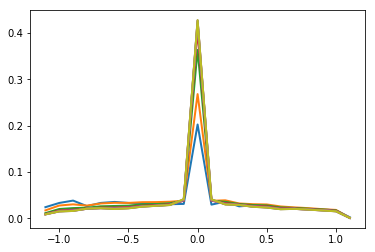

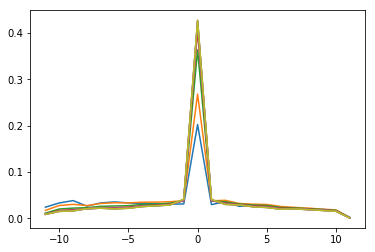

In [280]:
import matplotlib.pyplot as plt

dset = np.array([
    [ 0.02375977, 0.03289047, 0.03798805, 0.0260006, 0.03298376, 0.03511224, 0.03295891, 0.03141027, 0.03177493, 0.03012503, 0.0308199, 0.20243477, 0.02925136, 0.03582732, 0.02553062, 0.02762094, 0.02657878, 0.02307026, 0.02074506, 0.01998599, 0.01895336, 0.01683571, 0.00191822],
    [ 0.01686298, 0.02732773, 0.02985257, 0.02720021, 0.03174851, 0.03325109, 0.03298991, 0.03452874, 0.03471168, 0.03558591, 0.03773591, 0.2680995, 0.03753452, 0.03861921, 0.03179062, 0.03023895, 0.02965912, 0.02531557, 0.02328946, 0.02169529, 0.0195003, 0.01781263, 0.00105855],
    [ 0.01087773, 0.01984124, 0.02179573, 0.02261769, 0.02566882, 0.02636352, 0.02709081, 0.02968875, 0.03035245, 0.03242142, 0.03761318, 0.36349752, 0.03765178, 0.03535652, 0.0307126, 0.02841544, 0.02750409, 0.02327072, 0.02213591, 0.02044944, 0.0187849, 0.01683627, 0.00063696],
    [ 0.00894851, 0.01666739, 0.01824664, 0.02074884, 0.02291539, 0.02289326, 0.02395645, 0.02700148, 0.02796661, 0.03027069, 0.03765989, 0.40531237, 0.03762104, 0.03261524, 0.02946198, 0.02657603, 0.02543288, 0.02150821, 0.02101955, 0.01934389, 0.01788924, 0.015919, 0.00056382],
    [ 0.00843881, 0.01549137, 0.01686208, 0.02032311, 0.02199062, 0.0214206, 0.02262003, 0.02589932, 0.02708987, 0.02933106, 0.03837336, 0.42032343, 0.03821964, 0.03118883, 0.02888979, 0.02558433, 0.02426438, 0.02052015, 0.02045417, 0.01879447, 0.0173349, 0.01538653, 0.00055504],
    [ 0.00832013, 0.01501083, 0.01626003, 0.02032855, 0.02170078, 0.02073994, 0.02200336, 0.02543256, 0.02680578, 0.02891566, 0.03921424, 0.42532733, 0.03897929, 0.03048527, 0.02868821, 0.02510021, 0.02365272, 0.01998893, 0.02022109, 0.01858085, 0.01703134, 0.01511075, 0.00055654],
    [ 0.00829902, 0.01478217, 0.01595447, 0.02041979, 0.02161171, 0.0203793, 0.02167451, 0.02520356, 0.02671978, 0.0286973, 0.03992711, 0.42695623, 0.03964308, 0.03011556, 0.02862847, 0.0248553, 0.02332047, 0.01968582, 0.02013723, 0.01851941, 0.01686213, 0.01496897, 0.00055848],
    [ 0.00830249, 0.01458856, 0.01567217, 0.02057491, 0.0215833, 0.02003222, 0.02135286, 0.02499061, 0.02669122, 0.02846396, 0.04084442, 0.42764784, 0.04051407, 0.02977029, 0.02861419, 0.02464292, 0.023012, 0.01937966, 0.02011321, 0.01853742, 0.0167002, 0.01485365, 0.00056035],
    [ 0.00830473, 0.01454074, 0.01560344, 0.02062415, 0.02158703, 0.01994407, 0.02127596, 0.02493538, 0.02668992, 0.02838687, 0.04111657, 0.42770504, 0.04076724, 0.02968239, 0.02861568, 0.02459356, 0.02294204, 0.01929312, 0.02012009, 0.01856106, 0.01665952, 0.01483119, 0.00056067]
])

plt.plot([[i] * len(dset) for i in np.arange(-1.1, 1.2, 0.1)], dset.T, '-', linewidth=2)
plt.show()


plt.figure()
for d in dset:
    plt.plot(range(-11, 12), d, '-')
plt.show()